# Train first model

Training base model based on AlexNet architecture implemented in this kaggle notebook:
<br>
https://www.kaggle.com/vortexkol/alexnet-cnn-architecture-on-tensorflow-beginner

## Setup

In [46]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

# Plotting pretty figures and avoid blurry images
%config InlineBackend.figure_format = 'retina'

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print('Error')
        print(e)


1 Physical GPUs, 1 Logical GPUs


### Utils

In [44]:
def display_car_price(X, y, y_pred=None):
    num_images = 28
    
    plt.figure(figsize=(20, 10))
    for i, (img, price) in enumerate(zip(X[:num_images], y[:num_images])):
        ax = plt.subplot(4, 7, i + 1)    
        ax.imshow(img[:, :, 0], cmap='gray')
        if y_pred is not None:
            ax.set_title(f'{price} | {int(y_pred[i][0])}')
        else:
            ax.set_title(price)
        ax.axis('off')

### Load data

In [4]:
data_path = '../datasets/autoria/ready/image_price_128_gray_int_100k.npz'
data = np.load(data_path)

In [5]:
data.files

['X', 'y']

In [6]:
X = data['X']
y = data['y']

# All data don't fit into memory when converted to float
X = X[:50_000]
y = y[:50_000]

X.shape, y.shape

((50000, 128, 128, 1), (50000,))

In [7]:
X.dtype

dtype('uint8')

### Train-Validation split

In [8]:
# 80% for validation
train_pct = 0.8
split_point = int(X.shape[0] * train_pct)
split_point

40000

In [9]:
X_train = X[:split_point]
X_val   = X[split_point:]

y_train = y[:split_point]
y_val   = y[split_point:]

# free up memory
del X
del y

In [10]:
# normalize data
X_train = X_train.astype('float32') / 255
X_val = X_val.astype('float32') / 255

In [11]:
X_train.shape, y_train.shape

((40000, 128, 128, 1), (40000,))

In [12]:
X_val.shape, y_val.shape

((10000, 128, 128, 1), (10000,))

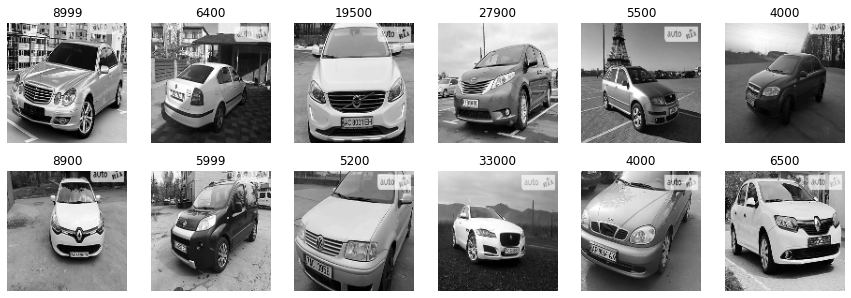

In [13]:
display_car_price(X_train, y_train)

### Model Setup

In [22]:
# (128, 128, 1)
input_shape = X_train.shape[1:]

def get_model():
    model = keras.Sequential([
        layers.Conv2D(filters=128, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPool2D(pool_size=(2,2)),

        layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
        layers.BatchNormalization(),
        layers.MaxPool2D(pool_size=(3,3)),

        layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
        layers.BatchNormalization(),

        layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
        layers.BatchNormalization(),

        layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
        layers.BatchNormalization(),
        layers.MaxPool2D(pool_size=(2,2)),

        layers.Flatten(),
        layers.Dense(1024,activation='relu'),
        layers.Dropout(0.3),

        layers.Dense(1024,activation='relu'),
        layers.Dropout(0.4),

        layers.Dense(10,activation='relu'),
        layers.Dense(1,activation='relu'),
    ])
        
    model.compile(optimizer='adam', 
                  loss=keras.losses.mape, 
                  metrics=[
                      keras.metrics.mean_squared_error,
                      keras.metrics.mean_absolute_error,
                      keras.metrics.mean_absolute_percentage_error
                  ])
    
    return model

In [23]:
model = get_model()

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 128)       15616     
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 128)       512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 15, 256)       819456    
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 15, 256)       1024      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 256)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 256)         5

### Train model

In [26]:
history = model.fit(X_train, y_train, 
                    batch_size=128, 
                    epochs=30, 
                    validation_data=(X_val, y_val))

Epoch 1/30
313/313 [==============================] - 27s 52ms/step - loss: 60.2109 - mean_squared_error: 238084275.9236 - mean_absolute_error: 7296.0545 - mean_absolute_percentage_error: 60.2109 - val_loss: 65.7683 - val_mean_squared_error: 359608416.0000 - val_mean_absolute_error: 9296.4307 - val_mean_absolute_percentage_error: 65.7683
Epoch 2/30
313/313 [==============================] - 15s 49ms/step - loss: 51.0819 - mean_squared_error: 203980135.0573 - mean_absolute_error: 6331.9781 - mean_absolute_percentage_error: 51.0819 - val_loss: 76.4306 - val_mean_squared_error: 390383968.0000 - val_mean_absolute_error: 10642.9756 - val_mean_absolute_percentage_error: 76.4306
Epoch 3/30
313/313 [==============================] - 15s 49ms/step - loss: 48.8345 - mean_squared_error: 213530625.0701 - mean_absolute_error: 6255.1651 - mean_absolute_percentage_error: 48.8345 - val_loss: 62.5862 - val_mean_squared_error: 344991872.0000 - val_mean_absolute_error: 8757.0332 - val_mean_absolute_perce

313/313 [==============================] - 16s 51ms/step - loss: 17.2143 - mean_squared_error: 154835829.1911 - mean_absolute_error: 3107.9526 - mean_absolute_percentage_error: 17.2143 - val_loss: 49.9298 - val_mean_squared_error: 250295280.0000 - val_mean_absolute_error: 5807.3794 - val_mean_absolute_percentage_error: 49.9298
Epoch 25/30
313/313 [==============================] - 16s 52ms/step - loss: 16.8462 - mean_squared_error: 145746154.9299 - mean_absolute_error: 2986.5981 - mean_absolute_percentage_error: 16.8462 - val_loss: 47.5955 - val_mean_squared_error: 251407104.0000 - val_mean_absolute_error: 5817.8550 - val_mean_absolute_percentage_error: 47.5955
Epoch 26/30
313/313 [==============================] - 16s 51ms/step - loss: 16.8185 - mean_squared_error: 150870235.6688 - mean_absolute_error: 2991.5935 - mean_absolute_percentage_error: 16.8185 - val_loss: 47.6402 - val_mean_squared_error: 244762464.0000 - val_mean_absolute_error: 5756.1890 - val_mean_absolute_percentage_erro

In [27]:
history.history.keys()

dict_keys(['loss', 'mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'val_loss', 'val_mean_squared_error', 'val_mean_absolute_error', 'val_mean_absolute_percentage_error'])

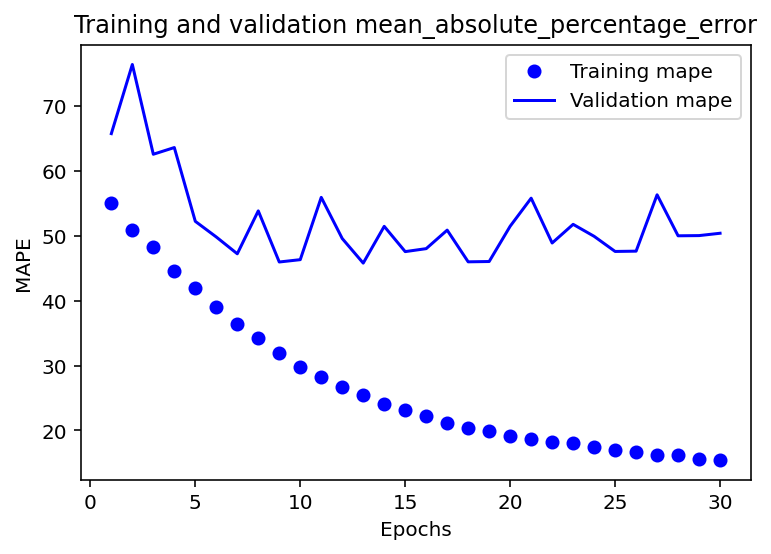

In [47]:
history_dict = history.history
mape_values = history_dict['mean_absolute_percentage_error']
val_mape_values = history_dict['val_mean_absolute_percentage_error']

plt.plot(epochs, mape_values, 'bo', label='Training mape')
plt.plot(epochs, val_mape_values, 'b', label='Validation mape')
plt.title('Training and validation mean_absolute_percentage_error')
plt.xlabel('Epochs')
plt.ylabel('MAPE')
plt.legend()
plt.show()

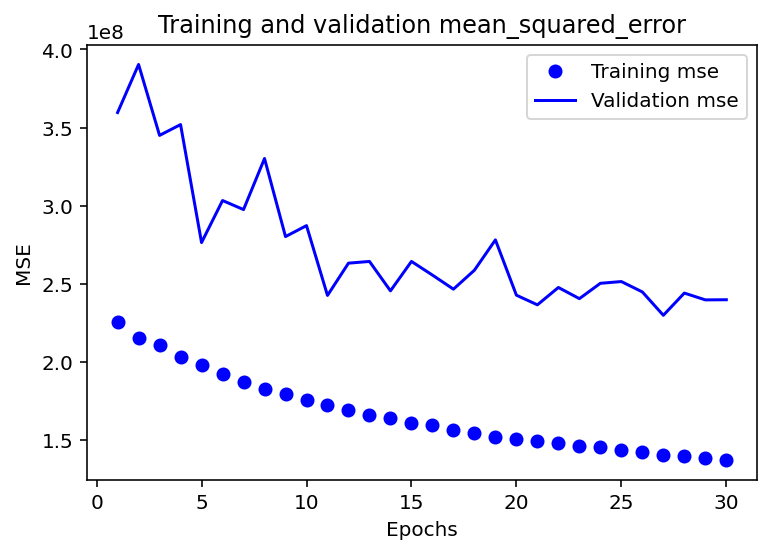

In [48]:
history_dict = history.history
mse_values = history_dict['mean_squared_error']
val_mse_values = history_dict['val_mean_squared_error']

plt.plot(epochs, mse_values, 'bo', label='Training mse')
plt.plot(epochs, val_mse_values, 'b', label='Validation mse')
plt.title('Training and validation mean_squared_error')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

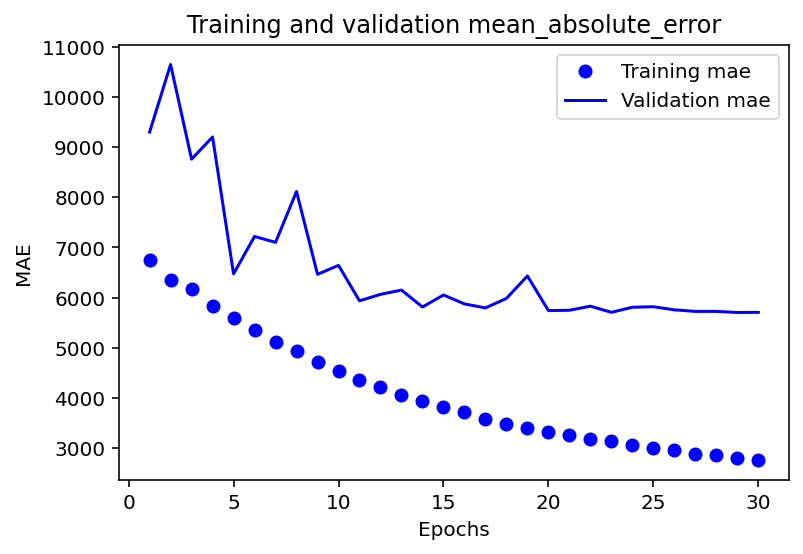

In [49]:
history_dict = history.history
mae_values = history_dict['mean_absolute_error']
val_mae_values = history_dict['val_mean_absolute_error']

plt.plot(epochs, mae_values, 'bo', label='Training mae')
plt.plot(epochs, val_mae_values, 'b', label='Validation mae')
plt.title('Training and validation mean_absolute_error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [50]:
y_pred = model.predict(X_val)

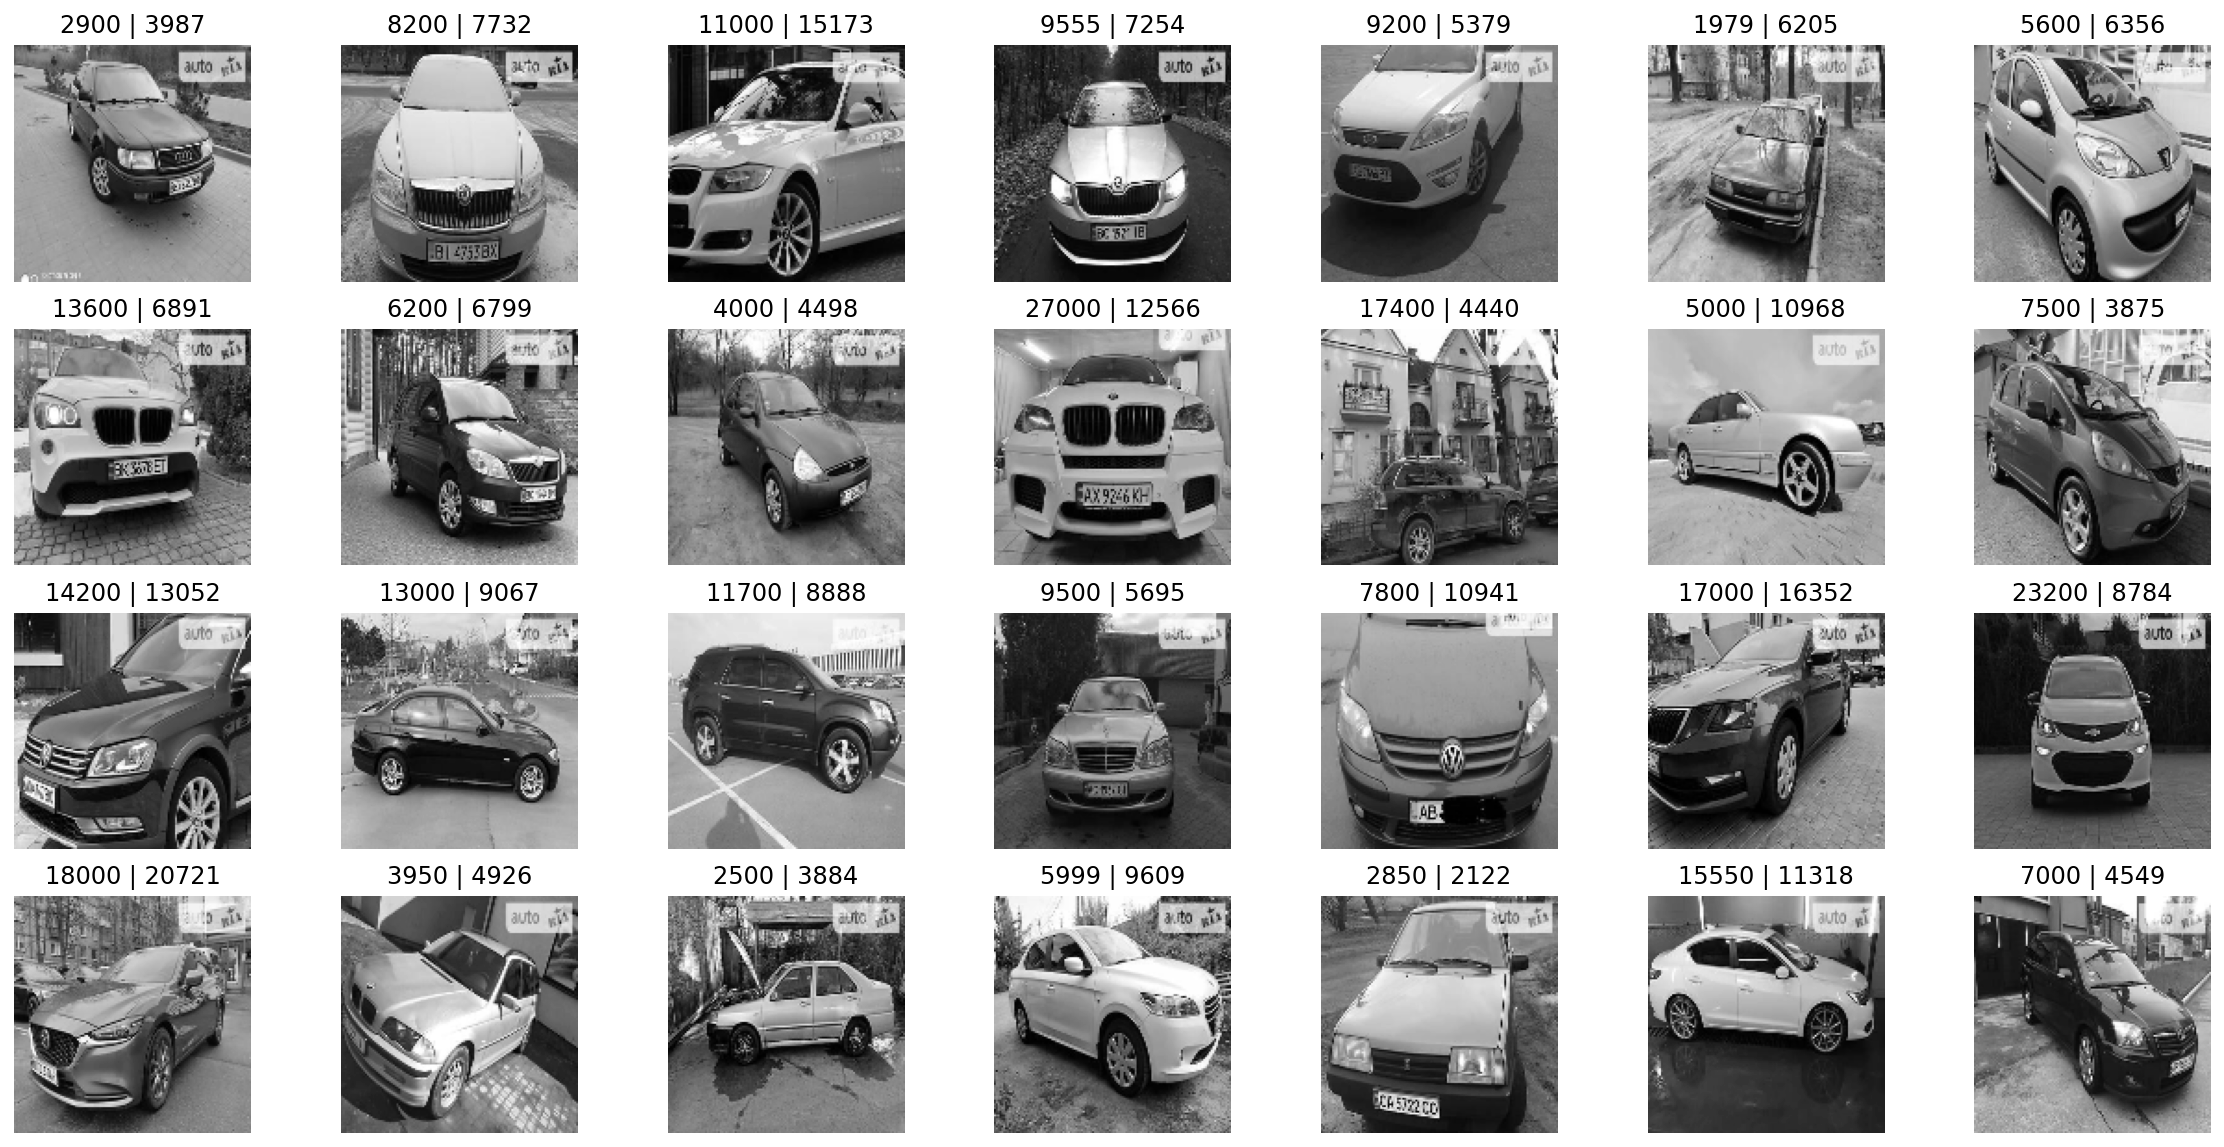

In [51]:
display_car_price(X_val, y_val, y_pred)
# true price | predicted price

### Saving model

In [53]:
model_path = 'models/0/'

In [52]:
model.save(model_path)

INFO:tensorflow:Assets written to: models/0/assets


**Loading saved model**

In [54]:
saved_model = tf.keras.models.load_model(model_path)

In [68]:
test_car = np.expand_dims(X_val[1], 0)
test_car.shape

(1, 128, 128, 1)

In [73]:
saved_model.predict(test_car)

array([[7731.2046]], dtype=float32)

In [74]:
y_val[1]

8200